<a href="https://colab.research.google.com/github/junyu-chen-academic/Transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################################
### importing libraries
######################################
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

seed = 2024
torch.manual_seed(seed)

# 1. Data Preprocessing

## 1.1 Word Embedding

In [ ]:
###########################################################
###########################################################
# tokenize the sequences
def tokenize(sequence):

    # remove punctuation
    for punc in ["!", ",", ".", "?"]:
        sequence = sequence.replace(punc, "")

    # split the sequence on spaces and lowercase each token
    return [token.lower() for token in sequence.split(" ")]

def build_vocab(data):

    # tokenize the data and remove duplicates
    vocab = list(set(tokenize(data)))

    # sort the vocabulary
    vocab.sort()

    # assign an integer to each word
    vocab = {word:i for i, word in enumerate(vocab)}

    return vocab

## 1.2 Positional Encoding

The original mapping we applied in positional encoding is
$$
\begin{align}
    p_{k,2i} &= \sin(\frac{k}{10000^{\frac{2i}{d}}}), \\
    p_{k,2i+1} &= \cos(\frac{k}{10000^{\frac{2i}{d}}}),
\end{align}
$$
for $k \in \{1, \ldots, n\}$ and $i \in \{0, \ldots, \frac{d}{2} - 1\}$. However, this basic implementation is not efficient due to its use of nested loops.

Instead, we modify the divisor using logarithmic rules:
$$
\begin{align}
    \frac{1}{10000^{\frac{2i}{d}}} = e^{\frac{-2i \log(n)}{d}}.
\end{align}
$$
It is apparent that only two divisors are necessary for a $4$-dimensional embedding since the divisor only changes every $2i$.

In [ ]:
###########################################################
###########################################################
class PositionalEncoding(nn.Module):

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.0,
        max_length: int = 5000
    ):
        """
        Args:
          d_model:      dimension of embeddings
          dropout:      probability of randomly zeroes-out some of the input
          max_length:   max sequence length
        """
        super().__init__()

        # initialize dropout
        self.dropout = nn.Dropout(p=dropout)
        # create a N x d tensor of zeros
        pe = torch.zeros(max_length, d_model)

        # calculate the numerator
        # unsqueeze(1) adds a new dimension at the first axis (index 1), transforming the 1D tensor into a 2D column vector.
        k = torch.arange(0, max_length).unsqueeze(1)

        # calculate the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * (- (math.log(10000.0) / d_model)))

        # calculate sine on even indices, and cosine on odd indices.
        pe[:, 0::2] = torch.sin(k * div_term)
        pe[:, 1::2] = torch.cos(k * div_term)

        # add dimension
        pe = pe.unsqueeze(0)

        # buffers are saved in state_dict but not trained by the optimizer
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor):
        """
        Args:
          x:        input embeddings (batch_size, seq_length, d_model)

        Returns:    embeddings + positional encodings (batch_size, seq_length, d_model)
        """
        # add positional encoding to the embeddings
        # note that the positional encoding tensor is sliced to match the length of the input sequence.
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)

        # perform dropout
        return self.dropout(x)

# 2. Model

Things to note:

1. we use nn.dropout to prevent overfitting. Dropout randomly zeroes out some values of the output.

2. We use the fully connected neural network in the feed forward layer.

## 2.1 Layers

### 2.1.1 Attention Layer

Each head undergoes single-head attention operation multiple times to obtain different attention scores:
$$
\begin{align}
    \mathbf{A}'_{(h)} &= \text{Attention}(\mathbf{Q}_{(h)},\mathbf{K}_{(h)},\mathbf{V}_{(h)}) = \text{softmax}(\frac{\mathbf{Q}_{(h)}\mathbf{K}_{(h)}^T}{\sqrt{d_{k}}})\mathbf{V}_{(h)}, \\
    \text{where }&
    \mathbf{Q}_{(h)}=\mathbf{X} \mathbf{W}_{q}^{(h)}, \quad
    \mathbf{K}_{(h)}=\mathbf{X} \mathbf{W}_{k}^{(h)}, \quad
    \mathbf{V}_{(h)}=\mathbf{X} \mathbf{W}_{v}^{(h)}.
\end{align}
$$

Here, $h$ denotes the number of heads, often $d_{k} = d_{v} = d/h$, and $\mathbf{W}_{q}^{(h)}, \mathbf{W}_{k}^{(h)}, \mathbf{W}_{v}^{(h)} \in \mathbb{R}^{d \times d_{k}}$.

Then, we concatenate attention outputs $\mathbf{A}'_{(h)}$ from all $h$ heads and linearly combine using a learnable weight matrix $\mathbf{W}_{a} \in \mathbb{R}^{hd_{v}\times d}$:
\begin{equation}
    \mathbf{A} = \text{Multi-Head}(\mathbf{Q},\mathbf{K},\mathbf{V}) = \text{Concat}(\mathbf{A}'_{(1)}, ..., \mathbf{A}'_{(h)}) \cdot W_{a},
\end{equation}
where $\mathbf{A} \in \mathbb{R}^{n \times d}$.

Note that the softmax function $\sigma : \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by the formula: $\sigma(\mathbf{z})_{i} = e^{z_{i}}/\sum_{j=1}^{n} e^{z_{j}}$ for $i = \{1,...,n\}$.

In [ ]:
###########################################################
###########################################################
class MultiHeadAttention(nn.Module):

    def __init__(
        self,
        d_model: int = 512,
        n_heads: int = 8,
        dropout: float = 0.1
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of self attention heads
            dropout:      probability of dropout occurring
        """
        super().__init__()
        torch.manual_seed(seed)
        assert d_model % n_heads == 0            # ensure an even num of heads
        self.d_model = d_model                   # dim (e.g. 512)
        self.n_heads = n_heads                   # 8 heads
        self.d_key = d_model // n_heads          # assume d_value equals d_key (e.g. 512/8=64)

        self.Wq = nn.Linear(d_model, d_model)    # query weights
        self.Wk = nn.Linear(d_model, d_model)    # key weights
        self.Wv = nn.Linear(d_model, d_model)    # value weights
        self.Wo = nn.Linear(d_model, d_model)    # output weights

        self.dropout = nn.Dropout(p=dropout)     # initialize dropout layer

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        mask: Tensor = None
    ):
        """
        Args:
           query:         query vector         (batch_size, q_length, d_model)
           key:           key vector           (batch_size, k_length, d_model)
           value:         value vector         (batch_size, s_length, d_model)
           mask:          mask for decoder

        Returns:
           output:        attention values     (batch_size, q_length, d_model)
           attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
        """
        batch_size = key.size(0)

        # calculate query, key, and value tensors
        Q = self.Wq(query)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)
        K = self.Wk(key)                         # (32, 10, 512) x (512, 512) = (32, 10, 512)
        V = self.Wv(value)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)

        # split each tensor into n-heads to compute attention

        # query tensor
        Q = Q.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = q_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, q_length, d_key)
        # key tensor
        K = K.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = k_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, k_length, d_key)
        # value tensor
        V = V.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = v_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, v_length, d_key)

        # computes attention
        # scaled dot product -> QK^{T} / sqrt(d_key)
        # (32, 8, 10, 64) x (32, 8, 64, 10) -> (32, 8, 10, 10) = (batch_size, n_heads, q_length, k_length)
        scaled_dot_prod = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_key)      # sqrt(64)

        # fill those positions of product as (-1e10) where mask positions are 0
        if mask is not None:
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask == 0, -1e10)

        # apply softmax
        attn_probs = torch.softmax(scaled_dot_prod, dim=-1)

        # multiply by values to get attention
        A = torch.matmul(self.dropout(attn_probs), V)       # (32, 8, 10, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64)
                                                            # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key) -> (batch_size, n_heads, q_length, d_key)

        # reshape attention back to (32, 10, 512)
        A = A.permute(0, 2, 1, 3).contiguous()              # (32, 8, 10, 64) -> (32, 10, 8, 64)
        A = A.view(batch_size, -1, self.n_heads * self.d_key) # (32, 10, 8, 64) -> (32, 10, 8*64) -> (32, 10, 512) = (batch_size, q_length, d_model)

        # push through the final weight layer
        output = self.Wo(A)                                 # (32, 10, 512) x (512, 512) = (32, 10, 512)

        return output, attn_probs                           # return attn_probs for visualization of the scores

### 2.1.2 Add and Norm Layer

Layer normalization speeds up convergence.

The LayerNorm function $g: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by $g(\mathbf{z}, \gamma, \beta)_{i} = \beta + \gamma \frac{(z_{i} - \mu_{z})}{\sigma_{z}}$. Here, $\mu_{z} = \frac{1}{n} \sum_{i=1}^{n} z_{i}$ and $\sigma_{z} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(z_{i} - \mu_{z})^{2})}$ denote the mean and standard deviation respectively, $\gamma$ and $\beta$ are parameters of the LayerNorm function. After normalization, the input is scaled by $\gamma$ and shifted by $\beta$.

In [ ]:
###########################################################
###########################################################
class LayerNorm(nn.Module):

    def __init__(
        self,
        d_model,
        eps=1e-5
    ):
        super().__init__()
        # initialize gamma to be all ones
        self.gamma = nn.Parameter(torch.ones(d_model))
        # initialize beta to be all zeros
        self.beta = nn.Parameter(torch.zeros(d_model))
        # eps: a small constant (1e-5) added to the variance to avoid division by zero during normalization.
        self.eps = eps

    def forward(self, src):
        # this computes the mean of the input src along the last dimension (-1), which represents the feature dimension.
        mean = src.mean(-1, keepdim=True)
        # this computes the variance of the input src along the last dimension (-1). unbiased=False means not divided by n-1 but by n.
        var = src.var(-1, keepdim=True, unbiased=False)
        # return the normalized value
        return self.gamma * (src - mean) / torch.sqrt(var + self.eps) + self.beta

### 2.1.3 Feed Forward Layer

It consists of two linear layers.

In [ ]:
###########################################################
###########################################################
class PositionwiseFeedForward(nn.Module):

  def __init__(
      self,
      d_model: int,
      d_ffn: int,
      dropout: float = 0.1
  ):
    """
    Args:
        d_model:      dimension of embeddings
        d_ffn:        dimension of feed-forward network,
                      generally set to a value about four times that of d_model.
        dropout:      probability of dropout occurring
    """
    super().__init__()

    self.w_1 = nn.Linear(d_model, d_ffn)
    self.w_2 = nn.Linear(d_ffn, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Args:
        x:            output from attention (batch_size, seq_length, d_model)

    Returns:
        expanded-and-contracted representation (batch_size, seq_length, d_model)
    """
    # w_1(x).relu():            (batch_size, seq_length, d_model) x (d_model, d_ffn)  ->    (batch_size, seq_length, d_ffn)
    # w_2(w_1(x).relu()):       (batch_size, seq_length, d_ffn) x (d_ffn, d_model)    ->    (batch_size, seq_length, d_model)
    return self.w_2(self.dropout(self.w_1(x).relu()))

## 2.2 Encoder-Decoder Structure

### 2.2.1 Encoder Block

Stacking each encoder layer forms the encoder block. The original paper by Vaswani et al. stacked 6 encoder layers.



In [ ]:
###########################################################
###########################################################
class EncoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          positionally embedded sequences   (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """
        # pass embeddings through multi-head attention
        _src, attn_probs = self.attention(query=src, key=src, value=src, mask=src_mask)

        # residual add and norm
        src = self.attn_layer_norm(src + self.dropout(_src))

        # position-wise feed-forward network
        _src = self.positionwise_ffn(x=src)

        # residual add and norm
        src = self.ffn_layer_norm(src + self.dropout(_src))

        return src, attn_probs


###########################################################
###########################################################
class Encoder(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          embedded sequences                (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """

        # pass the sequences through each encoder
        for layer in self.layers:
            src, attn_probs = layer(src=src, src_mask=src_mask)

        self.attn_probs = attn_probs

        return src

### 2.2.2 Decoder Block

Stacking each decoder layer forms the decoder block. The original paper by Vaswani et al. stacked 6 decoder layers.

In [ ]:

###########################################################
###########################################################
class DecoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        # masked multi-head attention sublayer
        self.masked_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for masked multi-head attention
        self.masked_attn_layer_norm = LayerNorm(d_model=d_model)

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          target embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          source embedded sequences                (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the target sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the source sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            trg:          sequences after self-attention    (batch_size, trg_seq_length, d_model)
            attn_probs:   attention softmax scores          (batch_size, n_heads, trg_seq_length, src_seq_length)
        """
        # pass trg embeddings through masked multi-head attention
        _trg, attn_probs = self.masked_attention(query=trg, key=trg, value=trg, mask=trg_mask)

        # residual add and norm
        trg = self.masked_attn_layer_norm(trg + self.dropout(_trg))

        # pass trg and src embeddings through multi-head attention
        _trg, attn_probs = self.attention(query=trg, key=src, value=src, mask=src_mask)

        # residual add and norm
        trg = self.attn_layer_norm(trg + self.dropout(_trg))

        # position-wise feed-forward network
        _trg = self.positionwise_ffn(x=trg)

        # residual add and norm
        trg = self.ffn_layer_norm(trg + self.dropout(_trg))

        return trg, attn_probs

###########################################################
###########################################################
class Decoder(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            vocab_size:   size of the vocabulary
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )
        self.dropout = nn.Dropout(p=dropout)
        # set output layer
        self.Wo = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask:
        Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          encoded sequences from encoder    (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            output:       sequences after decoder           (batch_size, trg_seq_length, vocab_size)
            attn_probs:   self-attention softmax scores     (batch_size, n_heads, trg_seq_length, src_seq_length)
        """

        # pass the sequences through each decoder
        for layer in self.layers:
            trg, attn_probs = layer(trg=trg, src=src, trg_mask=trg_mask, src_mask=src_mask)

        self.attn_probs = attn_probs

        return self.Wo(trg)

# 4. Time Series Forecasting Example (main process)

**Task definition:**

We want to predict the value of the next one time step given the observed 200 time steps.

## 4.1 Data Generation Process

1. The training dataset consists of a noisy sine wave with 1000 data points.

2. It is restructured for time series prediction, where each input sequence consists of 200 consecutive time steps, and the target is the next point in the sequence.

3. Input shape: 800 sequences, 200 time steps **(batch_size, sequence length, dimension)** = (800 x 200 x 1)

4. Target shape: 800 targets **(batch_size, dimension)** = (800 x 1)

In [ ]:
######################################
### Data settings
######################################
data_size = 1000
sequence_length = 200 # number of time steps per input sequence
d_model = 1 # dimension

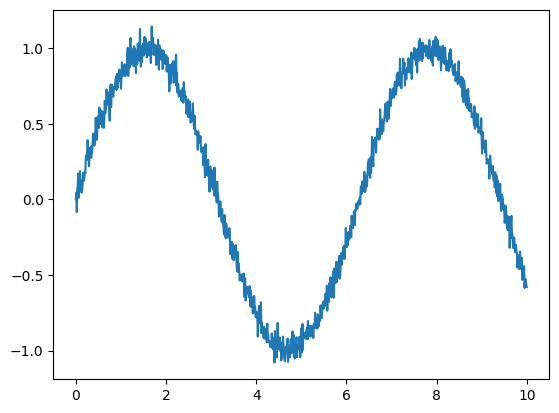

In [ ]:
# construct the sinus wave
x = np.linspace(0, 10, data_size)
y = np.sin(x)

# add some noise by N(mean=0, std=0.05)
y = y + np.random.normal(0, 0.05, data_size)

# plot
plt.plot(x, y)
plt.show()

In [ ]:
# create input-output pairs (X: input sequence, Y: target)
X = []
Y = []

for i in range(data_size - sequence_length):
    X.append(y[i : i + sequence_length])  # Take a sequence of `sequence_length` as input
    Y.append(y[i + sequence_length])     # The next point after the sequence is the target

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

print(f'X shape: {X.shape}')
print(f'Y shape: {Y.shape}')

# reshape X to (batch_size, sequence_length, d_model)
X = X.reshape(X.shape[0], X.shape[1], d_model)
Y = Y.reshape(len(Y), d_model)

print(f"Input shape: {Tensor(X).shape}")
print(f"Target shape: {Tensor(Y).shape}")

dataset = TensorDataset(Tensor(X), Tensor(Y))

# Create a DataLoader
batch_size = 32  # You can define your desired batch size here
dataloader = DataLoader(dataset, batch_size=12, shuffle=True)

X shape: (800, 200)
Y shape: (800,)
Input shape: torch.Size([800, 200, 1])
Target shape: torch.Size([800, 1])


## 4.2 Attention Applied to Time Series

 We use the attention mechanism followed by a feed-forward layer.

**Model Structure:**

The _TimeSeriesModel_ is a neural network model designed to predict time series data using attention mechanisms. Here's a brief description of the structure
- MultiHeadAttention Layer: capture dependencies in time series data.

- Linear Layers: passes the attention output through two linear layers with a ReLU activation to predict a single value:
  - The first linear layer maps the sequence back to its original length.
  - The second reduces the sequence to a single prediction value.

- Masking: A masking option prevents attention to future time steps.

In [ ]:
class TimeSeriesModel(nn.Module):
    def __init__(
        self,
        sequence_length: int,
        d_model: int = 512,
        n_heads: int = 8,
        dropout: float = 0.1
    ):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        self.linear_layer1 = nn.Linear(sequence_length, sequence_length)
        self.linear_layer2 = nn.Linear(sequence_length, 1)
        #self.linear_layer2 = nn.Linear(sequence_length, 64)
        #self.linear_layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(
        self,
        x: Tensor,
        mask_or_not: bool = True
    ):
        if mask_or_not == True:
          mask_matrix = torch.tril(torch.ones((x.size(1), x.size(1))))
          attention_out, _ = self.attention(x, x, x, mask_matrix)  # Using same input for query, key, value
        else:
          attention_out, _ = self.attention(x, x, x)  # Using same input for query, key, value

        # remove the d_model, as we want the 200 points in sequence to be mapped to 1 target
        attention_out = attention_out.squeeze(-1)
        output = self.linear_layer1(attention_out)
        output = self.relu(output)
        output = self.linear_layer2(output)
        #output = self.relu(output)
        #output = self.linear_layer3(output)

        return output

In [ ]:
######################################
### Model settings
######################################
n_heads = 1
dropout = 0
learning_rate = 0.00015
epochs = 20
batch_size = 8

In [ ]:
######################################
### Model training
######################################
model = TimeSeriesModel(sequence_length=sequence_length, d_model=d_model, n_heads=n_heads, dropout=dropout)

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(epochs):

  for input, target in dataloader:

    optimizer.zero_grad()
    # forward pass
    predicted = model(input, mask_or_not=True)
    # calculate loss
    loss = criterion(predicted, target)
    # backward pass
    loss.backward()
    # optimization
    optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")

Epoch [1/20], Loss: 0.1170
Epoch [2/20], Loss: 0.0391
Epoch [3/20], Loss: 0.0317
Epoch [4/20], Loss: 0.0105
Epoch [5/20], Loss: 0.0049
Epoch [6/20], Loss: 0.0047
Epoch [7/20], Loss: 0.0027
Epoch [8/20], Loss: 0.0033
Epoch [9/20], Loss: 0.0019
Epoch [10/20], Loss: 0.0021
Epoch [11/20], Loss: 0.0028
Epoch [12/20], Loss: 0.0035
Epoch [13/20], Loss: 0.0051
Epoch [14/20], Loss: 0.0045
Epoch [15/20], Loss: 0.0041
Epoch [16/20], Loss: 0.0061
Epoch [17/20], Loss: 0.0047
Epoch [18/20], Loss: 0.0022
Epoch [19/20], Loss: 0.0084
Epoch [20/20], Loss: 0.0015


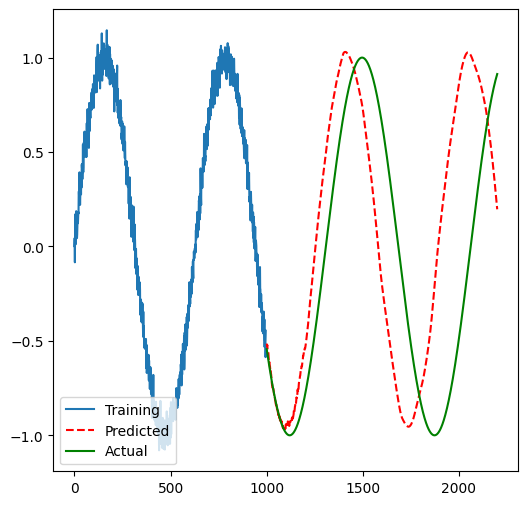

In [ ]:
######################################
### Model Evaluation
######################################
predict_timesteps = 1200
model.eval()

y_copy = y.copy()

# predict the next 1200 steps
for t in range(predict_timesteps):
  # extract the last sequence of the training points (200 points)
  input_pred = y_copy[len(y_copy) - sequence_length : len(y_copy)]
  # reshape (200,) -> (batch_size, sequence_length, d_model) = (1, 200, 1)
  input_pred = torch.Tensor(input_pred).view(1, input_pred.shape[0], 1)

  # predict
  output_pred = model(input_pred, mask_or_not = True)
  # reshape (1 x 1) -> (1)
  output_pred = output_pred.detach().numpy().reshape(1,)
  # append the predicted value to the time series
  y_copy = np.concatenate((y_copy, output_pred))



# Plot Predictions
fig = plt.figure(figsize=(6, 6))
plt.plot(
    range(y_copy[:data_size].shape[0]),
    y_copy[:data_size],
    label="Training"
)

plt.plot(
    range(y_copy[:data_size].shape[0], y_copy.shape[0]),
    y_copy[data_size : data_size + predict_timesteps],
    'r--',
    label="Predicted"
)
plt.plot(
    range(y_copy[:data_size].shape[0], y_copy.shape[0]),
    np.sin(np.linspace(10, 20, predict_timesteps)),
    'g-', label="Actual"
)
plt.legend(loc='lower left')

## 4.3 Encoder Applied to Time Series